In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gspread

Getting access to google drive

In [2]:
# Credential for Loging in;
credentials = {"installed":{"client_id":"87512639134-lt7advfrbavuji436aqu5r6rt888mols.apps.googleusercontent.com","project_id":"gspread-361806","auth_uri":"https://accounts.google.com/o/oauth2/auth","token_uri":"https://oauth2.googleapis.com/token","auth_provider_x509_cert_url":"https://www.googleapis.com/oauth2/v1/certs","client_secret":"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","redirect_uris":["http://localhost"]}}

# gc, authorized_user = gspread.oauth_from_dict(credentials,auth_user)
gc, authorized_user = gspread.oauth_from_dict(credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=87512639134-lt7advfrbavuji436aqu5r6rt888mols.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A50450%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fspreadsheets+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=uyE5Ym3Jnqr7DeMgM8ehZhx3M5uutI&access_type=offline


Accessing all the sheets required

In [3]:
data = gc.open("BSE500").sheet1 #---Opening the main stock exchange data;
persons_expenses=gc.open("Income / Expense").get_worksheet(0) #---Opening data of a singles persons monthly expense;
final_report1=gc.open("Final Report").get_worksheet(0) #---Opening first sheet of the final report sheet;
final_report2=gc.open("Final Report").get_worksheet(1) #---Second sheet of final report;

Converted to DataFrame

In [4]:
BSE_DATA = data.get_all_records()
BSE_DATA = pd.DataFrame(BSE_DATA)
expenses = persons_expenses.get_all_records()
expenses = pd.DataFrame(expenses)
BSE_DATA.head()

,Company,BSE code,NSE code,ISIN,Sector,Industry,Date,Price,1 day change(%),52 Week Low,...,Dividend Yield(%),EV / EBITDA,Price / Sales,Price / Cash Flow,Earning Per Share,Book Value Per Share,Cash Flow Per Share,Free Cash Flow Per Share,Dividend Per Share,Delta
0,Reliance Industries Ltd.,500325,RELIANCE,INE002A01018,Energy,Oil Refineries & Marketing,2022-09-05,2569.80,1.55,2180.00,...,0.31,13.28,2.17,15.71,98.12,1180.26,163.57,-3.04,8.0,0.10
1,Tata Consultancy Services Ltd.,532540,TCS,INE467B01029,Technology,Software,2022-09-05,3133.40,0.10,2953.00,...,1.37,18.94,5.76,28.69,106.03,268.29,109.15,101.88,43.0,0.23
2,HDFC Bank Ltd.,500180,HDFCBANK,INE040A01026,Financial,Banking,2022-09-05,1495.05,0.64,1271.60,...,1.04,12.97,5.9,-69.58,71.34,463.4,-21.57,-54.65,15.5,0.13
3,Infosys Ltd.,500209,INFY,INE009A01021,Technology,Software,2022-09-05,1461.30,0.57,1367.15,...,2.12,17.13,4.8,25.74,52.94,190.39,56.98,52.57,31.0,0.25
4,ICICI Bank Ltd.,532174,ICICIBANK,INE090A01021,Financial,Banking,2022-09-05,882.45,1.15,643.00,...,0.57,13.04,6.21,10.57,39.83,267.24,83.63,61.77,5.0,0.01


Net Income and Expense particular person

In [5]:
expenses=expenses.loc[:,expenses.columns!='INR'] #---Select all columns except one;
IE=expenses.groupby('Income/Expense').sum()
print(IE)
income=IE.Amount[1]
expense=IE.Amount[0]

                  Amount
Income/Expense          
Expense         57918.28
Income          68254.00


Got total income/expenditure for all categories

In [6]:
categories=expenses.groupby('Category').sum()
dic={'Allowance':0}
for cat in categories.Amount.index:
    dic[cat]=categories[categories.index==cat].Amount[0]

dic['Net Income']=income
dic['Net Expense']=expense
dic['Available for investment']=income-expense
dic

{'Allowance': 14000.0,
 'Apparel': 3388.0,
 'Beauty': 196.0,
 'Education': 1400.0,
 'Food': 23396.76,
 'Gift': 115.0,
 'Household': 12188.0,
 'Other': 51368.0,
 'Petty cash': 3.0,
 'Salary': 8000.0,
 'Self-development': 400.0,
 'Social Life': 2513.7200000000003,
 'Transportation': 9203.8,
 'Net Income': 68254.0,
 'Net Expense': 57918.28,
 'Available for investment': 10335.720000000001}

Updating to Reporting Sheet

In [66]:
for key in dic.keys():
    row=final_report1.find(key).row
    col=final_report1.find(key).col
    final_report1.update_cell(row,col+1,dic[key])
    print('Success')

Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success


Creating a new column For Delta

In [7]:
# Function to convert pure numerical format;
def only_nums(n):
    n=str(n)
    text=''
    for i in n:
        if i in '1234567890.-':
            text+=i
        else:
            pass
    try:    
        text=float(text)
    except:
        text=0
    return text

In [8]:
# Converting some columns to numerical columns;
BSE_DATA.Price=BSE_DATA.Price.apply(only_nums)
BSE_DATA['52 Week High']=BSE_DATA['52 Week High'].apply(only_nums)
BSE_DATA['Delta']=(BSE_DATA['52 Week High']-BSE_DATA.Price)/BSE_DATA['52 Week High']
delta=BSE_DATA.Delta.tolist()

Updating Delta column

In [69]:
import time

data.update_acell('AP1','Delta')

# for n,ele in enumerate(delta):
#     data.update_acell(f'AP{2+n}',ele)
#     if n%50==0:
#         time.sleep(40)


{'spreadsheetId': '1YNCi-YN1Qsq1lLGEak0eMMu08NygPH9Vr-zagAezijs',
 'updatedRange': "'bse500'!AP1",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

Filtering from the new column

In [9]:
BSE_DATA['Dividend Per Share']=BSE_DATA['Dividend Per Share'].apply(only_nums)
BSE_DATA['Market Cap(Cr)']=BSE_DATA['Market Cap(Cr)'].apply(only_nums)
BSE_DATA['10-Year Return(%)']=BSE_DATA['10-Year Return(%)'].apply(only_nums)

High risk taking stocks;

In [10]:
high=BSE_DATA[BSE_DATA.Delta>0]
high=high[high['Market Cap(Cr)'] < 3400]
high=high[high['10-Year Return(%)']<8]

high_risk=high.sort_values(by='Dividend Per Share',ascending=False).head().Company
high_risk

494          Thyrocare Technologies Ltd.
498    Advanced Enzyme Technologies Ltd.
496         Hathway Cable & Datacom Ltd.
499          Strides Pharma Science Ltd.
500                        SpiceJet Ltd.
Name: Company, dtype: object

Risk taking stocks;

In [11]:
risk=BSE_DATA[BSE_DATA.Delta>0]
risk=risk[risk['Market Cap(Cr)'].between(3400, 5000)]
risk=risk[risk['10-Year Return(%)'].between(8,15)]
risk_taking=risk.sort_values(by='Dividend Per Share',ascending=False).head().Company
risk_taking

464               NCC Ltd.
466       Tata Coffee Ltd.
476    Greaves Cotton Ltd.
465               FDC Ltd.
Name: Company, dtype: object

Moderate risk taking stock;

In [12]:
moderate=BSE_DATA[BSE_DATA.Delta>0]
moderate=moderate[moderate['Market Cap(Cr)'].between(5000, 15000)]
moderate=moderate[moderate['10-Year Return(%)'].between(15,20)]
moderate_risk=moderate.sort_values(by='Dividend Per Share',ascending=False).head().Company

moderate_risk

332                             Cyient Ltd.
356                     Graphite India Ltd.
361                  Birla Corporation Ltd.
411                           Symphony Ltd.
263    Chambal Fertilisers & Chemicals Ltd.
Name: Company, dtype: object

Low risk taking stock;

In [13]:
low=BSE_DATA[BSE_DATA.Delta>0]
low=low[low['Market Cap(Cr)'] > 15000]
low=low[low['10-Year Return(%)'] > 20]

low_risk=low.head().sort_values(by='Dividend Per Share',ascending=False).head().Company

In [14]:
all_companies=high_risk.tolist()+risk_taking.tolist()+moderate_risk.tolist()+low_risk.tolist()
all_companies

['Thyrocare Technologies Ltd.',
 'Advanced Enzyme Technologies Ltd.',
 'Hathway Cable & Datacom Ltd.',
 'Strides Pharma Science Ltd.',
 'SpiceJet Ltd.',
 'NCC Ltd.',
 'Tata Coffee Ltd.',
 'Greaves Cotton Ltd.',
 'FDC Ltd.',
 'Cyient Ltd.',
 'Graphite India Ltd.',
 'Birla Corporation Ltd.',
 'Symphony Ltd.',
 'Chambal Fertilisers & Chemicals Ltd.',
 'Bajaj Finance Ltd.',
 'Asian Paints Ltd.',
 'Reliance Industries Ltd.',
 'Kotak Mahindra Bank Ltd.',
 'Adani Enterprises Ltd.']

In [15]:
final_list=[]
for lis in [high_risk,risk_taking,moderate_risk,low_risk]:
    for n in range(5):
        try:
            final_list.append(lis.iloc[n])
        except:
            final_list.append('Nil')
            pass

Uploading data to Google sheet

In [86]:
for n,ele in enumerate(final_list):
    final_report2.update_acell('G'f'{2+n}',f'{ele}')

# Comparing median of Value of enterprice(Cr) across different Sectors

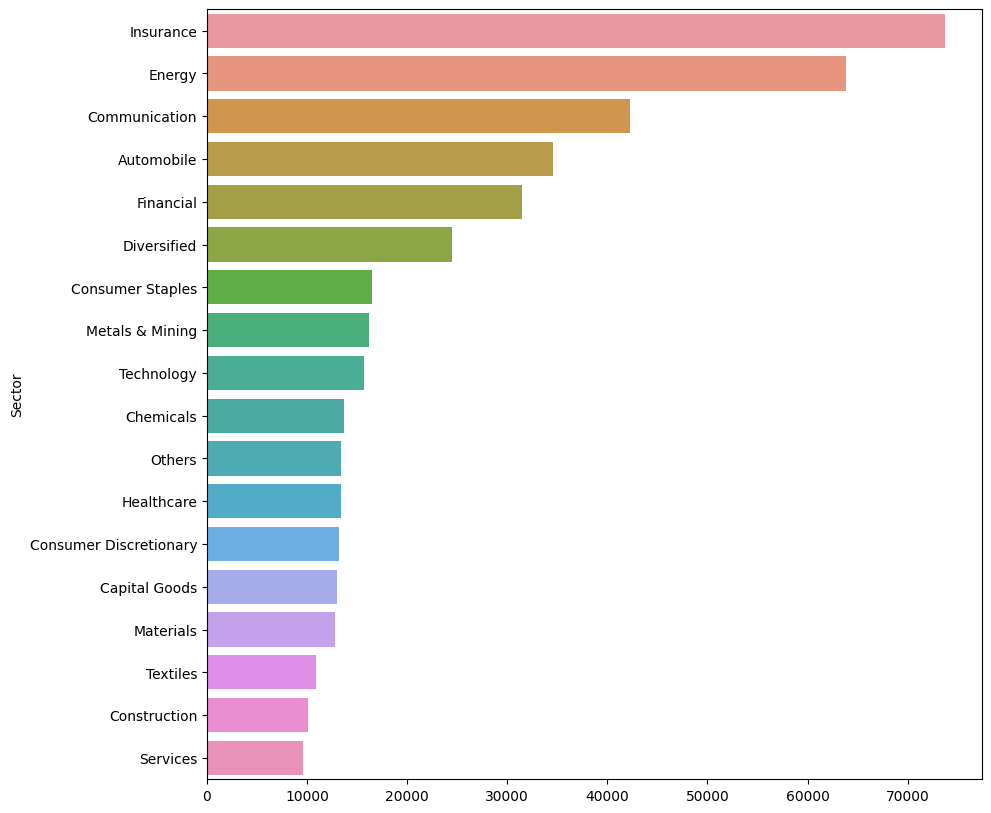

In [16]:
BSE_DATA['Enterprise Value(Cr)']=BSE_DATA['Enterprise Value(Cr)'].apply(only_nums)
median_of_sectors=BSE_DATA[['Sector','Enterprise Value(Cr)']].groupby('Sector').median()
s=median_of_sectors['Enterprise Value(Cr)'].sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(y=s.index,x=s.values)
plt.show()

# Is There any Relation between Dividend Per Share with Market Cap(Cr)

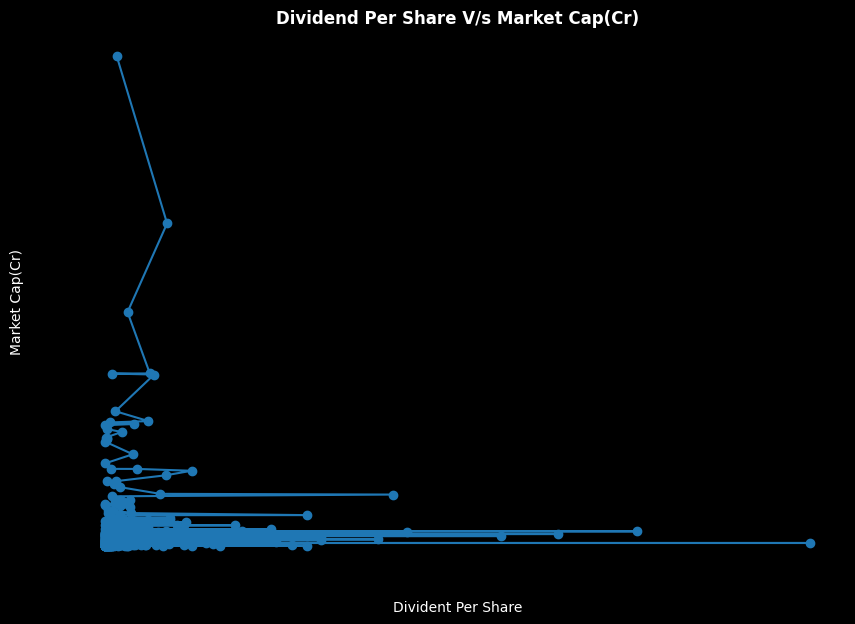

In [17]:
BSE_DATA['Dividend Per Share']=BSE_DATA['Dividend Per Share'].apply(only_nums)
plt.figure(figsize=(10,7),edgecolor='white',facecolor='black')
ax=plt.axes()

ax.set_facecolor('black')
plt.scatter(BSE_DATA['Dividend Per Share'],BSE_DATA['Market Cap(Cr)'])
plt.plot(BSE_DATA['Dividend Per Share'],BSE_DATA['Market Cap(Cr)'])
plt.rcParams['axes.edgecolor'] = 'white'
plt.xlabel('Divident Per Share',color='white')
plt.ylabel('Market Cap(Cr)',color='white')
plt.title('Dividend Per Share V/s Market Cap(Cr)', fontweight='bold',color='white')
plt.show()

<!-- Companies in different Industry with positive and negative 3-Year Return -->

# Industry With Positive 3-Year Return

In [21]:
BSE_DATA['3-Year Return']

0       0.16
1      41.31
2      11.82
3      24.18
4       9.51
       ...  
496    32.95
497     4.16
498   -34.57
499         
500    65.83
Name: 3-Year Return, Length: 501, dtype: object

In [ ]:
Best_industry_with_3_years_return = BSE_DATA[['Industry','Company','3-Year Return']]
Best_industry_with_3_years_return['3-Year Return']=Best_industry_with_3_years_return['3-Year Return'].apply(only_nums)  #--- Making data graph compactible;

lis=[]
for n, ele in enumerate(Best_industry_with_3_years_return['3-Year Return']):
    if ele>0:
        lis.append('+ve')
    else:
        lis.append('-ve')

Best_industry_with_3_years_return['Positive/Negative']=lis
Best_industry_with_3_years_return=Best_industry_with_3_years_return[['Industry','Positive/Negative']]
Best_industry_with_3_years_return=Best_industry_with_3_years_return[Best_industry_with_3_years_return['Positive/Negative']=='+ve']
Best_industry_with_3_years_return=Best_industry_with_3_years_return.groupby('Industry').count()['Positive/Negative'].sort_values(ascending=False) #--- Making data graph compactible;
Best_industry_with_3_years_return=Best_industry_with_3_years_return.head(15)

The real plot

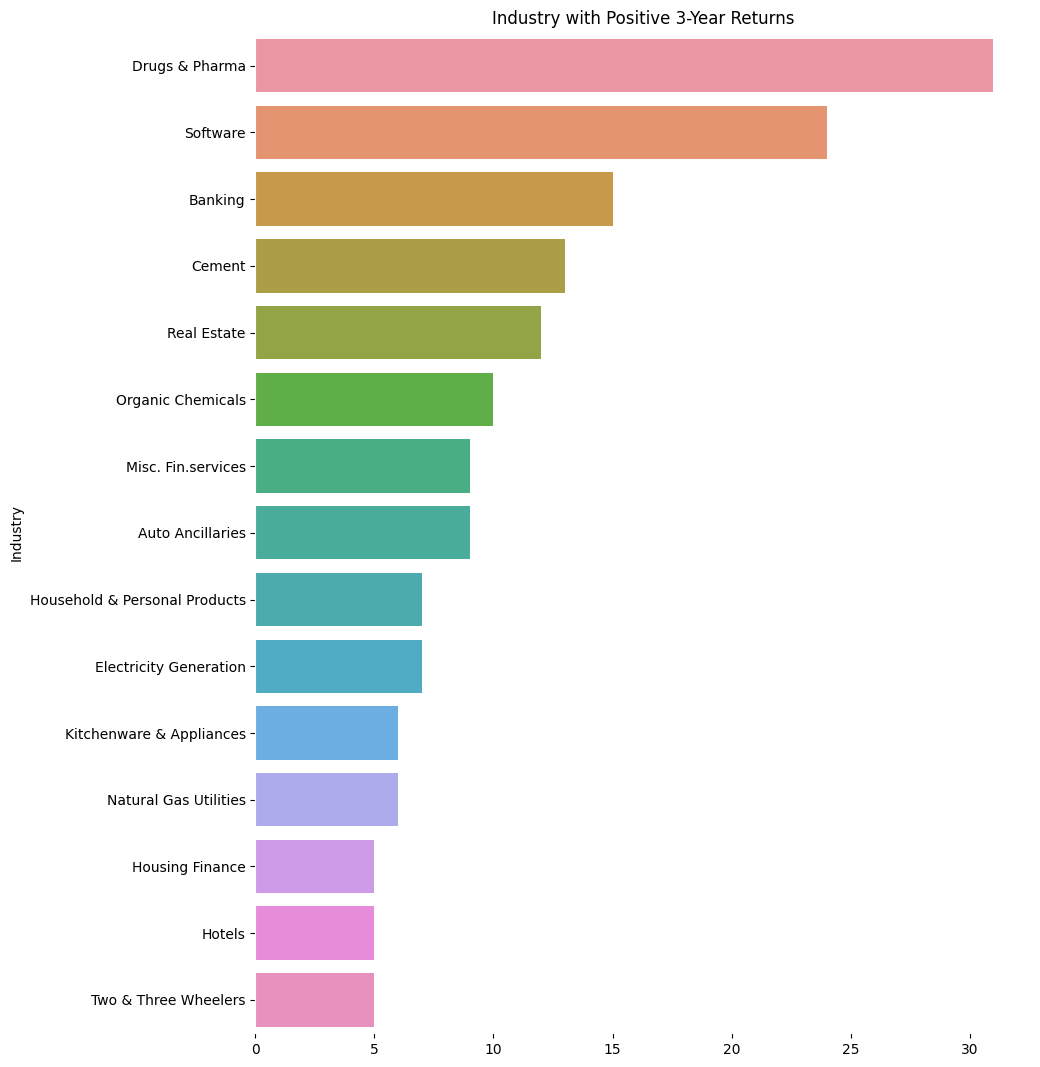

In [19]:
plt.figure(figsize=(10,13))
# sns.set(font_scale=2)
sns.barplot(x=Best_industry_with_3_years_return.values, y=Best_industry_with_3_years_return.index)
plt.title('Industry with Positive 3-Year Returns')
plt.show()

Best KPI for selecting best company stock

In [24]:
# There were 18 distinct sectors
# In each sector there are many companies
# KPI is Key Performance Indicator
# There are many KPI's than can decide the best stock in each sector like EV / EBITDA,Price to Earnings,
# Dividend Per Share,Price earnings to growth,Price to Book etc.
#  We choose our KPI as Price to Earnings
# Price to Earnings = share price/earning per share
# We thought that if earning per share is more means companies are doing a good business. They have works,projects
# ,market in their control.
# So higher is earning per share, lesser will be Price to Earnings and hence
# company with least Price to Earnings will be the best stock of that sector.


Top 10 Company with Highest PE Ratio

In [20]:
BSE_DATA['Price to Earnings']=BSE_DATA['Price to Earnings'].apply(only_nums)
Company_with_best_PE = BSE_DATA[['Company','Price to Earnings']].sort_values(by='Price to Earnings', ascending=False).head(10)
Company_with_best_PE

,Company,Price to Earnings
16,Adani Green Energy Ltd.,770.74
13,Adani Total Gas Ltd.,767.48
10,Adani Transmission Ltd.,443.21
15,Adani Enterprises Ltd.,391.52
412,Bombay Burmah Trading Corporation Ltd.,387.31
285,KIOCL Ltd,231.78
111,The Indian Hotels Company Ltd.,220.56
455,Just Dial Ltd.,200.69
321,Westlife Development Ltd.,184.67
468,Johnson Controls - Hitachi Air Conditioning In...,173.62


<AxesSubplot:xlabel='Price to Earnings', ylabel='Company'>

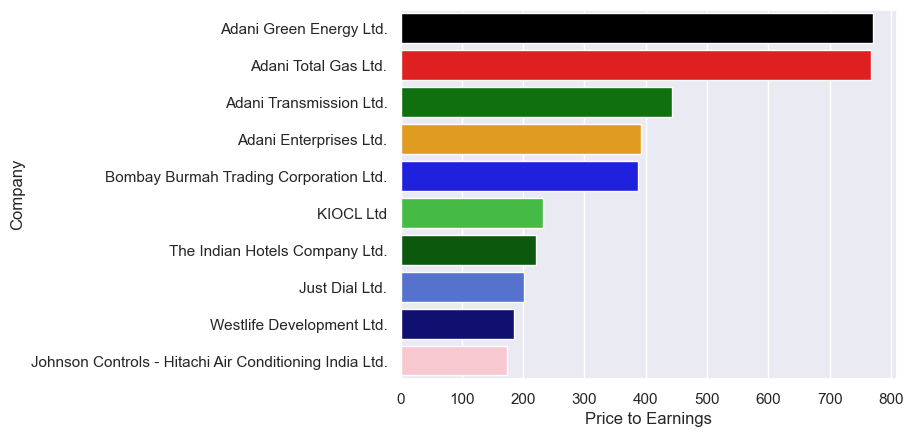

In [24]:
sns.set(font_scale=1)
color = ['black','red','green','orange','blue','limegreen','darkgreen','royalblue','navy','pink']
sns.barplot(x=Company_with_best_PE['Price to Earnings'],y=Company_with_best_PE.Company, palette=color)

In [27]:
# ISIN: An International Securities Identification Number (ISIN) is a 12-digit alphanumeric code
#  that uniquely identifies a specific security.
#  The organization that allocates ISINs in any particular country is the country's respective
#  National Numbering Agency (NNA).

In [28]:
# Enterprise value: is the total value of a company including the companies total markert market
#  capital and its net debt;
# Market capital is the total price of outstanding shares of a company in the market;
#  Its calculated by multiplying total outstanding shares * its each shares price in the stock market;